In [36]:
import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import ADASYN
import warnings
warnings.filterwarnings("ignore")

In [18]:
df_stroke = pd.read_csv("../../data/stroke_datasets/stroke.csv")

print("-----------Stroke Dataset---------- \n")
print(df_stroke.head())

-----------Stroke Dataset---------- 

   gender   age  hypertension  heart_disease ever_married      work_type  \
0    Male  67.0             0              1          Yes        Private   
1  Female  61.0             0              0          Yes  Self-employed   
2    Male  80.0             0              1          Yes        Private   
3  Female  49.0             0              0          Yes        Private   
4  Female  79.0             1              0          Yes  Self-employed   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Urban             228.69  36.6  formerly smoked       1  
1          Rural             202.21   NaN     never smoked       1  
2          Rural             105.92  32.5     never smoked       1  
3          Urban             171.23  34.4           smokes       1  
4          Rural             174.12  24.0     never smoked       1  


In [19]:
#Replace NaN bmi values
df_stroke["bmi"] = df_stroke["bmi"].replace(np.NaN, df_stroke["bmi"].mean())
df_stroke['bmi'] = df_stroke['bmi'].round(2)

#one hot encoding stroke 
df_encoded_stroke = pd.get_dummies(df_stroke, columns = ['gender', 'smoking_status','ever_married','work_type','Residence_type'])
df_encoded_stroke['id'] = range(1, len(df_encoded_stroke) + 1)

#convert the boolean features in integer (0,1)
boolean_columns = df_encoded_stroke.select_dtypes(include=bool).columns
for column in boolean_columns:
    df_encoded_stroke[column] = df_encoded_stroke[column].astype(int)

#unamed columns
unamed_column = [col for col in df_encoded_stroke.columns if col.startswith('Unnamed:') or col == '']
df_encoded_stroke = df_encoded_stroke.drop(columns = unamed_column)

print(df_encoded_stroke.head())

    age  hypertension  heart_disease  avg_glucose_level    bmi  stroke  \
0  67.0             0              1             228.69  36.60       1   
1  61.0             0              0             202.21  28.89       1   
2  80.0             0              1             105.92  32.50       1   
3  49.0             0              0             171.23  34.40       1   
4  79.0             1              0             174.12  24.00       1   

   gender_Female  gender_Male  gender_Other  smoking_status_Unknown  ...  \
0              0            1             0                       0  ...   
1              1            0             0                       0  ...   
2              0            1             0                       0  ...   
3              1            0             0                       0  ...   
4              1            0             0                       0  ...   

   ever_married_No  ever_married_Yes  work_type_Govt_job  \
0                0                 1  

In [20]:
# Separate the features (X) and the labels (y)
X = df_encoded_stroke.drop(['stroke','id'], axis=1)
y = df_encoded_stroke['stroke'] 

# Apply ADASYN to oversample the minority class
adasyn = ADASYN(random_state=43)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Create a new DataFrame with the balanced data
data_adasyn = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
data_adasyn['bmi'] = data_adasyn['bmi'].round(2)
data_adasyn['age'] = data_adasyn['age'].astype(int)

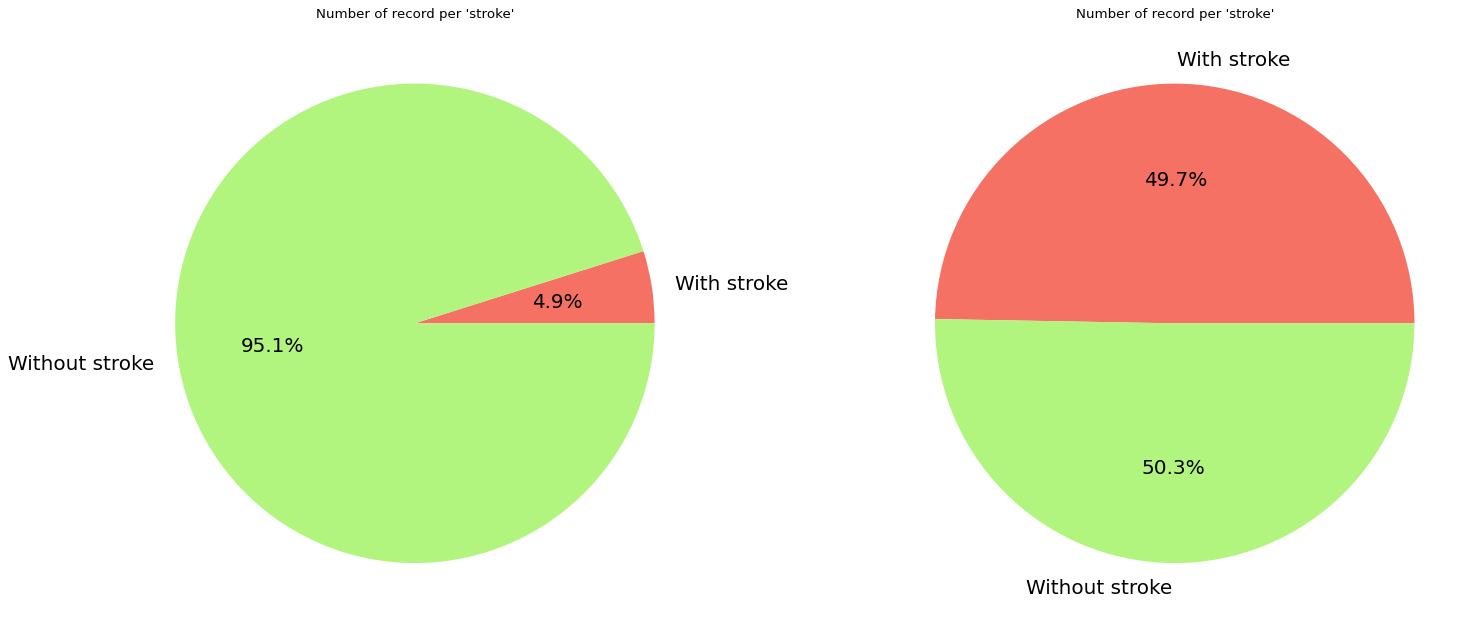

In [21]:
data_standard = df_encoded_stroke

def plot_stroke_pie_chart(dataframe):
    #Pie Plot
    disease_0 = dataframe.loc[dataframe["stroke"] == 0, :].shape[0]
    disease_1 = dataframe.loc[dataframe["stroke"] == 1, :].shape[0]

    labels = ["With stroke", "Without stroke"]
    sizes = [disease_1, disease_0]
    colors = ["#F57163", "#B2F57E"]
    plt.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%", textprops={'fontsize': 18})
    plt.title("Number of record per 'stroke'")
    plt.plot()
    
plt.figure(figsize=(20, 8), dpi=80)  # Adjust width, height, and dpi as needed
plt.subplot(1, 2, 1)
plot_stroke_pie_chart(data_standard)
plt.subplot(1, 2, 2)
plot_stroke_pie_chart(data_adasyn)
plt.tight_layout()
plt.show()

In [22]:
X_standard = data_standard.drop(['stroke','id'], axis=1)
y_standard = data_standard['stroke']

start = 42
maxIter = 30
step = 100
results_random_forest = []
results_k = []
results_log_reg = []
i = 0
while i < maxIter:
    seed = np.random.seed(42 + step)
    # Apply ADASYN to oversample the minority class
    adasyn = ADASYN(random_state=seed)
    X_train_sta, X_test_sta, y_train_sta, y_test_sta = train_test_split(X_standard, y_standard, random_state=seed)
   
    X_test_ada, y_test_ada = adasyn.fit_resample(X_test_sta, y_test_sta)

    # Fit models on X_train and y_train without oversampling
    model_random_forest =  RandomForestClassifier().fit(X_train_sta, y_train_sta)
    model_k = KNeighborsClassifier().fit(X_train_sta, y_train_sta)
    model_log_reg = LogisticRegression().fit(X_train_sta, y_train_sta)

    # Prediction on oversampled X_test_sta (X_test_ada)
    pred_random_forest = model_random_forest.predict(X_test_ada)
    pred_k = model_k.predict(X_test_ada)
    pred_log_reg = model_log_reg.predict(X_test_ada)

    # Accuracy for the models
    accuracy_random_forest = accuracy_score(y_test_ada, pred_random_forest)
    accuracy_k = accuracy_score(y_test_ada, pred_k)
    accuracy_log_reg = accuracy_score(y_test_ada, pred_log_reg)

    # Append the result of each iteration for the accuracy of the models in a list 
    results_random_forest.append(accuracy_random_forest)
    results_k.append(accuracy_k)
    results_log_reg.append(accuracy_log_reg)
    #print("iteration number: " + str(i) + " With seed number: " + str(42+step))
    i = i + 1
    step = step + 100
# Compute the variance for the models
variance_random_forest = np.var(results_random_forest)
variance_k = np.var(results_k)
variance_log_reg = np.var(results_log_reg)

print("Random Forest Variance: ", variance_random_forest)
print("K Neighbour Variance: ", variance_k)
print("Logistic Regression Variance: ", variance_log_reg)

Random Forest Variance:  6.759113989292909e-06
K Neighbour Variance:  2.6603722992392286e-05
Logistic Regression Variance:  0.0005764128410546942


In [23]:
# Apply ADASYN to oversample the minority class
adasyn = ADASYN(random_state=start)

X_train_sta, X_test_sta, y_train_sta, y_test_sta = train_test_split(X_standard, y_standard, random_state=start)
X_test_ada, y_test_ada = adasyn.fit_resample(X_test_sta, y_test_sta)

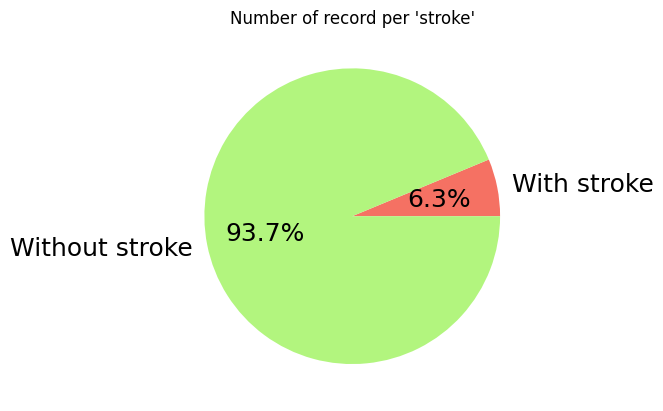

In [24]:
#Check frequency stroke
y_test_sta_df = pd.DataFrame({'stroke': y_test_sta})
plot_stroke_pie_chart(y_test_sta_df)
plt.show()

In [25]:
#------------ KNeighborsClassifier ------------
model_k =  KNeighborsClassifier().fit(X_train_sta, y_train_sta)
pred_k = model_k.predict(X_test_ada)

#------------ RandomForestClassifier ------------
model_random_forest =  RandomForestClassifier().fit(X_train_sta, y_train_sta)
pred_random_forest = model_random_forest.predict(X_test_ada)

#------------ LogisticRegression ------------
model_logistic =  LogisticRegression().fit(X_train_sta, y_train_sta)
pred_logistic = model_logistic.predict(X_test_ada)


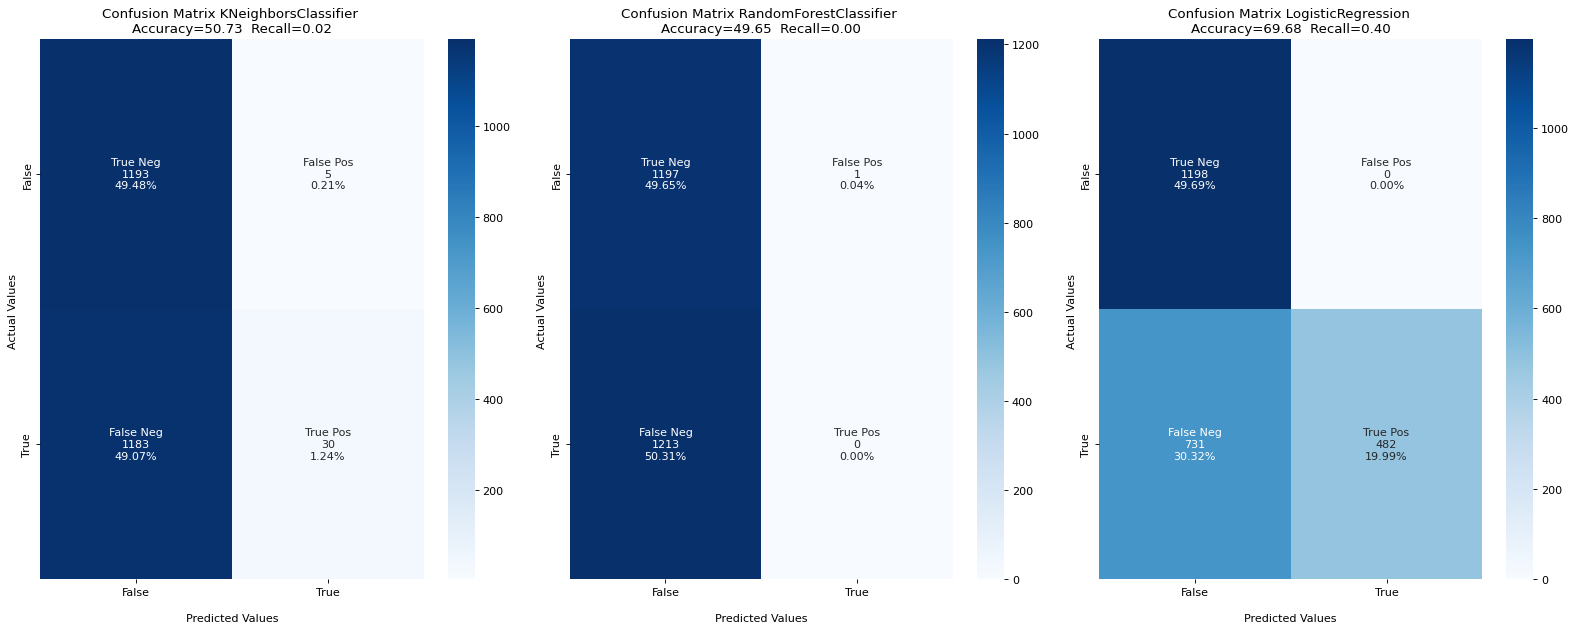

In [26]:
# Calculate the confusion matrix for the model KNeighborsClassifier
confusion_matrix_k = confusion_matrix(y_test_ada, pred_k)
accuracy_k = accuracy_score(y_test_ada, pred_k)*100
recall_k = recall_score(y_test_ada, pred_k)

# Calculate the confusion matrix for the model RandomForestClassifier
confusion_matrix_random_forest = confusion_matrix(y_test_ada, pred_random_forest)
accuracy_random_forest = accuracy_score(y_test_ada, pred_random_forest)*100
recall_random_forest = recall_score(y_test_ada, pred_random_forest)

# Calculate the confusion matrix for the model LogisticRegression
confusion_matrix_logistic = confusion_matrix(y_test_ada, pred_logistic)
accuracy_logistic = accuracy_score(y_test_ada, pred_logistic)*100
recall_logistic = recall_score(y_test_ada, pred_logistic)

def plot_matrix_model(model,accuracy,recall,confusion_matrix):
    #plot matrix
    #plt.ion()
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                    confusion_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                        confusion_matrix.flatten()/np.sum(confusion_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')

    ax.set_title("Confusion Matrix {:s} \nAccuracy={:.2f}  Recall={:.2f}".format(model,accuracy, recall));
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.plot()
    
plt.figure(figsize=(20, 8), dpi=80)  # Adjust width, height, and dpi as needed
plt.subplot(1, 3, 1)
plot_matrix_model("KNeighborsClassifier",accuracy_k,recall_k,confusion_matrix_k)
plt.subplot(1, 3, 2)
plot_matrix_model("RandomForestClassifier",accuracy_random_forest,recall_random_forest,confusion_matrix_random_forest)
plt.subplot(1, 3, 3)
plot_matrix_model("LogisticRegression",accuracy_logistic,recall_logistic,confusion_matrix_logistic)
plt.tight_layout()
plt.show()


In [35]:
#Compute the explainer for shap for the models
explainer_random_forest = shap.Explainer(model_random_forest.predict,X_test_ada)
explainer_k = shap.Explainer(model_k.predict,X_test_ada)
explainer_linear = shap.Explainer(model_logistic.predict,X_test_ada)

#Compute the shap values for the models
shap_values_random_forest = explainer_random_forest(X_standard[0:100])
shap_values_k = explainer_k(X_standard[0:100])
shap_values_linear = explainer_linear(X_standard[0:100])

PermutationExplainer explainer: 101it [00:11,  1.28it/s]                         
PermutationExplainer explainer: 101it [00:47,  1.66it/s]                         


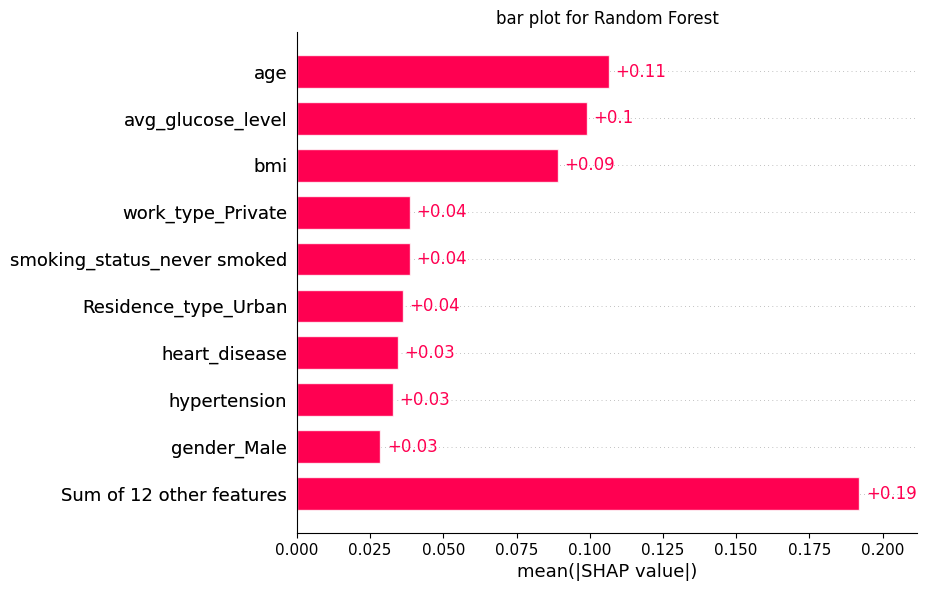

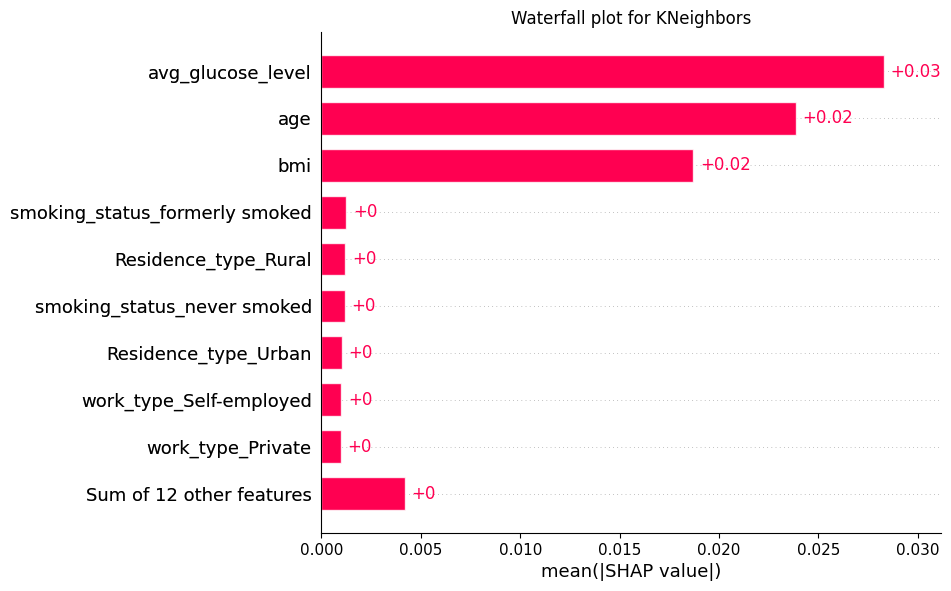

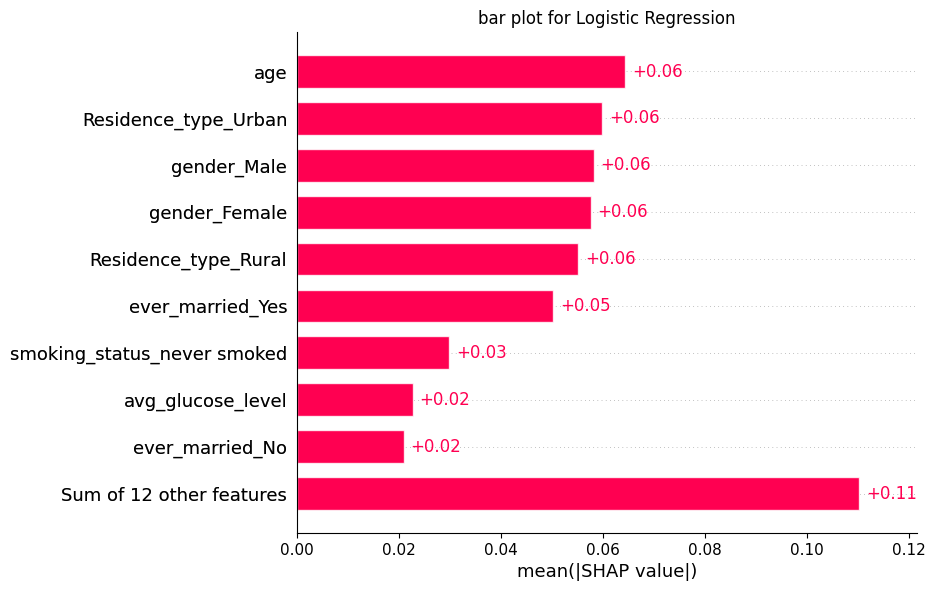

In [29]:
#bar plot for models
shap.plots.bar(shap_values_random_forest, show=False)
plt.title("bar plot for Random Forest")
plt.show()

shap.plots.bar(shap_values_k, show=False)
plt.title("Waterfall plot for KNeighbors")
plt.show()

shap.plots.bar(shap_values_linear, show=False)
plt.title("bar plot for Logistic Regression")
plt.show()

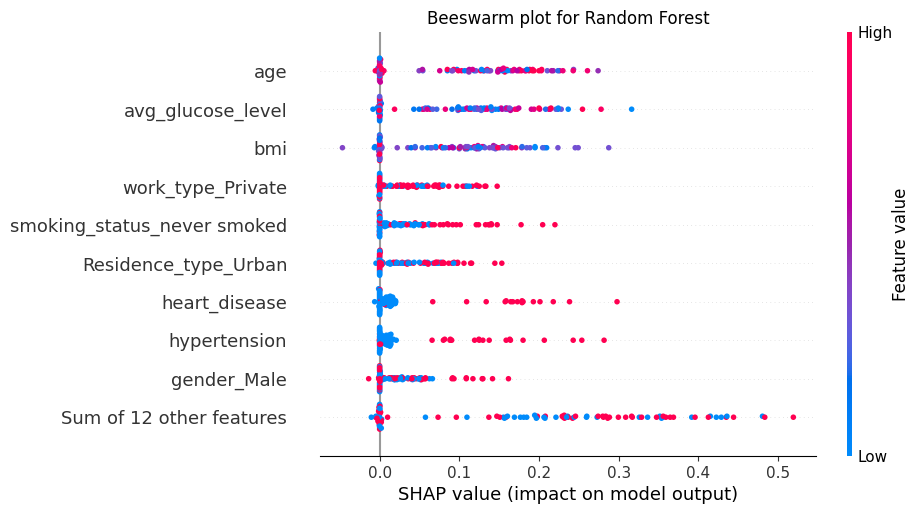

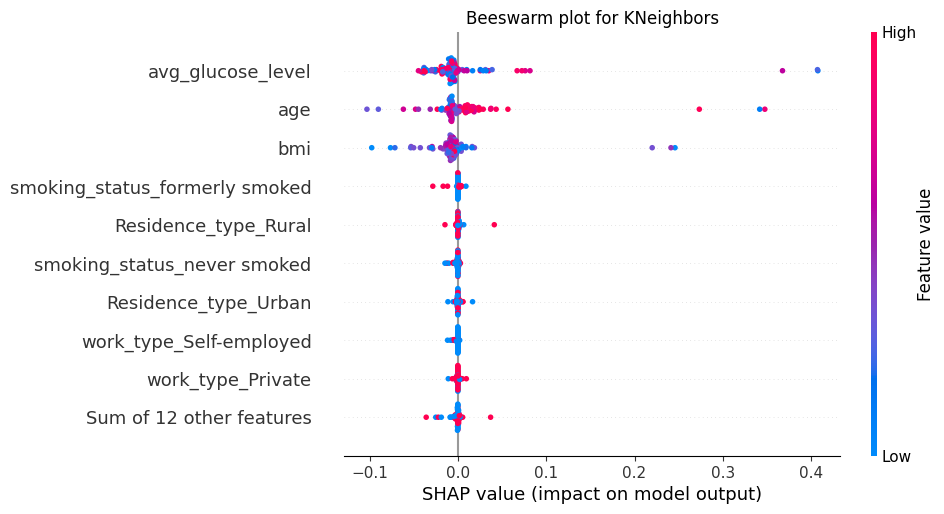

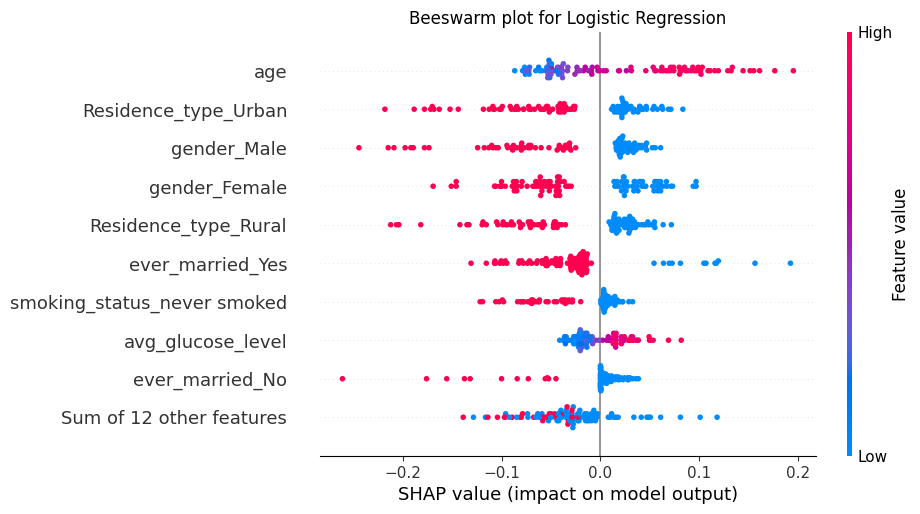

In [30]:
#beeswarm plot for models
shap.plots.beeswarm(shap_values_random_forest, show=False)
plt.title("Beeswarm plot for Random Forest")
plt.show()

shap.plots.beeswarm(shap_values_k, show=False)
plt.title("Beeswarm plot for KNeighbors")
plt.show()

shap.plots.beeswarm(shap_values_linear, show=False)
plt.title("Beeswarm plot for Logistic Regression")
plt.show()